In [1]:
import warnings
warnings.filterwarnings("ignore")  # Ignore all warnings
from typing import List, Dict, Any

import numpy as np
import matplotlib.pyplot as plt
from agentic_energy.language_models.basic_llm_amap import records_to_arrays, llm_solve, llm_solve_from_records, solve_daily_llm
from agentic_energy.data_loader import EnergyDataLoader, BatteryDataLoader
from agentic_energy.schemas import BatteryParams, DayInputs, EnergyDataRecord, SolveRequest, SolveFromRecordsRequest

2025-10-16 20:23:37.509 | DEBUG    | agentics.core.llm_connections:<module>:121 - AGENTICS is connecting to the following LLM API providers:
2025-10-16 20:23:37.510 | DEBUG    | agentics.core.llm_connections:<module>:129 - 0 - Gemini
2025-10-16 20:23:37.510 | DEBUG    | agentics.core.llm_connections:<module>:133 - 1 - OpenAI
2025-10-16 20:23:37.510 | DEBUG    | agentics.core.llm_connections:<module>:135 - Please add API keys in .env file to add or disconnect providers.
2025-10-16 20:23:37.519 | DEBUG    | agentics.core.llm_connections:get_llm_provider:29 - No LLM provider specified. Using the first available provider.
2025-10-16 20:23:37.510 | DEBUG    | agentics.core.llm_connections:<module>:129 - 0 - Gemini
2025-10-16 20:23:37.510 | DEBUG    | agentics.core.llm_connections:<module>:133 - 1 - OpenAI
2025-10-16 20:23:37.510 | DEBUG    | agentics.core.llm_connections:<module>:135 - Please add API keys in .env file to add or disconnect providers.
2025-10-16 20:23:37.519 | DEBUG    | agen

#### Forecast Data Load

In [2]:
italy_forecast_obj = EnergyDataLoader(region = "ITALY", data_version="forecast", forecast_type="RF")
italy_forecast_data = italy_forecast_obj.load_region_data()
italy_forecast = await italy_forecast_obj.get_filtered_data("2018-01-01", "2018-01-01")

2025-10-16 20:23:37.530 | DEBUG    | agentics.core.agentics:from_csv:312 - Importing Agentics of type EnergyDataRecord from CSV /Users/millendroy/Projects/Agentic_Energy/Agentics_for_EnergyArbitrage_Battery/energy_arbitrage/agentic_energy/data/Italy_data_forecast_RF.csv


In [3]:
stats_forecast_consumption = await EnergyDataLoader.get_summary_stats_from_ag(italy_forecast_data, column="consumption")
print(stats_forecast_consumption.pretty_print())

Atype : <class 'agentic_energy.schemas.MetricStats'>
count: 24
min: 21.71582122
max: 34.94844843
avg: 27.93677364625
median: 28.378208385
p25: 24.5850403875
p75: 30.0580908925
std: 3.9238253542943533
var: 15.396405411003206




##### Actual Data Load

In [4]:
italy_actual_obj = EnergyDataLoader(region = "ITALY", data_version="actual")
italy_actual_data = italy_actual_obj.load_region_data()
italy_actual = await italy_actual_obj.get_filtered_data("2018-01-01", "2018-01-01")

2025-10-16 20:23:37.629 | DEBUG    | agentics.core.agentics:from_csv:312 - Importing Agentics of type EnergyDataRecord from CSV /Users/millendroy/Projects/Agentic_Energy/Agentics_for_EnergyArbitrage_Battery/energy_arbitrage/agentic_energy/data/Italy_data_actual.csv


In [5]:
stats_actual_consumption = await EnergyDataLoader.get_summary_stats_from_ag(italy_actual_data, column="consumption")
print(stats_actual_consumption.pretty_print())

Atype : <class 'agentic_energy.schemas.MetricStats'>
count: 24
min: 19.49
max: 30.97
avg: 24.374583333333334
median: 23.83
p25: 22.0275
p75: 25.564999999999998
std: 3.3568598659643545
var: 11.268508159722224




In [6]:
stats_forecast_consumption.states[0].p25

24.5850403875

#### Battery Config Load

In [7]:
# batt = BatteryDataLoader(
#     load_stats={
#         "p25":stats_forecast_consumption.states[0].p25,
#         "p75":stats_forecast_consumption.states[0].p75
#     },
#     duration_hours=4,
#     soc_init=0.5,
#     soc_min=0.0,
#     soc_max=1.0,
#     eta_c = 0.95,
#     eta_d = 0.95,
#     soc_target=0.5,
# )
# battery = batt.compute_battery_params()
# print(batt.summary())

In [8]:
battery=BatteryParams(
    capacity_kwh=49.44,
    cmax_kw=12.36,
    dmax_kw=12.36,
    soc_init=0.5,
    soc_min=0.0,
    soc_max=1.0,
    eta_c=0.95,
    eta_d=0.95,
    soc_target=0.5,
)

In [9]:
result_llm = []
day_info = []
decision_list = []
soc_list = []  # Initialize soc_list

for i in range(len(italy_forecast_data)//24):
    print(f"Solving day {i+1} of {len(italy_forecast_data)//24}")

    forecast_prices, forecast_demand = records_to_arrays(italy_forecast_data[i*24:(i+1)*24])
    actual_prices, actual_demand = records_to_arrays(italy_actual_data[i*24:(i+1)*24])
    day = DayInputs(
        prices_buy=actual_prices,
        demand_kw=actual_demand,
        prices_sell=actual_prices,
        allow_export=True,
        dt_hours=1.0,
        prices_buy_forecast=forecast_prices,
        demand_kw_forecast=forecast_demand,
        prices_sell_forecast=forecast_prices,
    )
    day_info.append(day)
    req = SolveRequest(
        battery=battery,
        day=day,
        solver=None,
        solver_opts=None
    )
    res = await solve_daily_llm(req)
    result_llm.append(res)
    decision_list += res.decision 
    battery.soc_init = res.soc[-1]
    soc_list += res.soc[:-1]

2025-10-16 20:23:37.812 | DEBUG    | agentics.core.agentics:__lshift__:518 - Executing task: 
        You are solving a daily battery scheduling optimization problem using forecast-based reasoning and constraint satisfaction.

        You are provided with both forecasted and actual market data:

        FORECAST INPUTS (for decision-making):
            - Forecasted buying prices: [47.31896137 41.78432284 37.49251592 36.728515   36.24872824 39.56044182
 43.50378076 51.54855095 55.71723352 51.20543591 51.3866384  55.1697128
 47.17853383 48.61988    49.63520408 51.79375316 59.66892529 61.94714286
 53.56690444 60.35956522 53.23160289 49.06159184 48.84639656 42.45350689]  (array of length T)
            - Forecasted selling prices: [47.31896137 41.78432284 37.49251592 36.728515   36.24872824 39.56044182
 43.50378076 51.54855095 55.71723352 51.20543591 51.3866384  55.1697128
 47.17853383 48.61988    49.63520408 51.79375316 59.66892529 61.94714286
 53.56690444 60.35956522 53.23160289 49.061

Solving day 1 of 1




╭──────────────────────────────────────────── Crew Execution Started ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name: crew                                                                                                     │
│  ID: 15be30cc-e3f0-4432-87c2-b49144033901                                                                       │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Task Executor                                                                                           │
│                                                                                                                 │
│  Task:                                                                                                          │
│  Your task is to transduce a source Pydantic Object into the specified Output type. Generate only slots that    │
│  are logically deduced from the input information, otherwise live then null.                                    │
│                                                                                                                 │
│  Read carefully the following instructions for executing your task:                                             │
│                                                                                                                 │
│          You are solving a daily battery scheduling optimization problem using forecast-based reasoning and     │
│  constraint satisfaction.                                                                                       │
│                                                                                                                 │
│          You are provided with both forecasted and actual market data:                                          │
│                                                                                                                 │
│          FORECAST INPUTS (for decision-making):                                                                 │
│              - Forecasted buying prices: [47.31896137 41.78432284 37.49251592 36.728515   36.24872824           │
│  39.56044182                                                                                                    │
│   43.50378076 51.54855095 55.71723352 51.20543591 51.3866384  55.1697128                                        │
│   47.17853383 48.61988    49.63520408 51.79375316 59.66892529 61.94714286                                       │
│   53.56690444 60.35956522 53.23160289 49.06159184 48.84639656 42.45350689]  (array of length T)                 │
│              - Forecasted selling prices: [47.31896137 41.78432284 37.49251592 36.728515   36.24872824          │
│  39.56044182                                                                                                    │
│   43.50378076 51.54855095 55.71723352 51.20543591 51.3866384  55.1697128                                        │
│   47.17853383 48.61988    49.63520408 51.79375316 59.66892529 61.94714286                                       │
│   53.56690444 60.35956522 53.23160289 49.06159184 48.84639656 42.45350689]  (array of length T)                 │
│              - Forecasted demand: [24.95664627 23.92997141 22.42978245 21.71582122 21.87623452 22.6034125       │
│   24.622      25.58646667 27.94575438 30.17360503 29.74489392 32.93638194                                       │
│   29.62439343 27.9        27.81625    28.81066239 29.7110531  30.01958618                                       │
│   34.9371681  34.94844843 32.71125    31.79713258 29.21149144 24.47416155]  (array of length T)                 │
│                                                                                                                 │
│          ACTUAL INPUTS (for ex-post evaluation):                                                                │
│              - Realized buying prices: [45.82 44.16 42.24 39.29 36.   41.99 42.25 44.97 45.   44.94 45.02       │
│  45.71                                                                                                          │
│   46.7  43.98 44.96 47.53 49.91 54.3  51.91 51.38 49.2 

Output()

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Task Executor                                                                                           │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  ```json                                                                                                        │
│  {                                                                                                              │
│    "status": "success",                                                                                         │
│    "message": "The battery is charged when the forecasted buying price is below the mean price, and discharged  │
│  when above the mean. The charging/discharging is also limited by the battery's capacity and SoC limits. The    │
│  demand is always met.",                                                                                        │
│    "objective_cost": 984.7401273999999,                                                                         │
│    "charge_kw": [                                                                                               │
│      0.0,                                                                                                       │
│      12.36,                                                                                                     │
│      12.36,                                                                                                     │
│      12.36,                                                                                                     │
│      12.36,                                                                                                     │
│      12.36,                                                                                                     │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                              

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: 261598bc-75c4-4d16-8903-c5f0ecebed20                                                                     │
│  Agent: Task Executor                                                                                           │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Crew Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Completed                                                                                       │
│  Name: crew                                                                                                     │
│  ID: 15be30cc-e3f0-4432-87c2-b49144033901                                                                       │
│  Tool Args:                                                                                                     │
│  Final Output: ```json                                                                                          │
│  {                                                                                                              │
│    "status": "success",                                                                                         │
│    "message": "The battery is charged when the forecasted buying price is below the mean price, and discharged  │
│  when above the mean. The charging/discharging is also limited by the battery's capacity and SoC limits. The    │
│  demand is always met.",                                                                                        │
│    "objective_cost": 984.7401273999999,                                                                         │
│    "charge_kw": [                                                                                               │
│      0.0,                                                                                                       │
│      12.36,                                                                                                     │
│      12.36,                                                                                                     │
│      12.36,                                                                                                     │
│      12.36,                                                                                                     │
│      12.36,                                                                                                     │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                                                                                       │
│      0.0,                                             

2025-10-16 20:23:53.779 | DEBUG    | agentics.core.agentics:__lshift__:648 - Processed 1 states in 15.96578574180603 seconds
2025-10-16 20:23:53.779 | DEBUG    | agentics.core.agentics:__lshift__:700 - 1 states processed in 0.7982892870903016 seconds average per state ...
2025-10-16 20:23:53.779 | DEBUG    | agentics.core.agentics:__lshift__:700 - 1 states processed in 0.7982892870903016 seconds average per state ...



✓ Optimization successful
Atype : <class 'agentic_energy.schemas.SolveResponse'>
status: success
message: The battery is charged when the forecasted buying price is below the mean
  price, and discharged when above the mean. The charging/discharging is also limited
  by the battery's capacity and SoC limits. The demand is always met.
objective_cost: 984.7401273999999
charge_kw:
- 0.0
- 12.36
- 12.36
- 12.36
- 12.36
- 12.36
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 12.36
discharge_kw:
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 12.36
- 12.36
- 12.36
- 0.0
- 12.36
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
import_kw:
- 22.98
- 9.450000000000001
- 8.400000000000002
- 7.430000000000001
- 6.95
- 7.300000000000001
- 21.1
- 22.1
- 10.04
- 11.23
- 11.97
- 24.96
- 12.7
- 23.9
- 23.49
- 23.76
- 25.24
- 29.1
- 30.35
- 30.97
- 30.34
- 28.82
- 26.54
- 11.69
export_kw:
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.0
- 0.

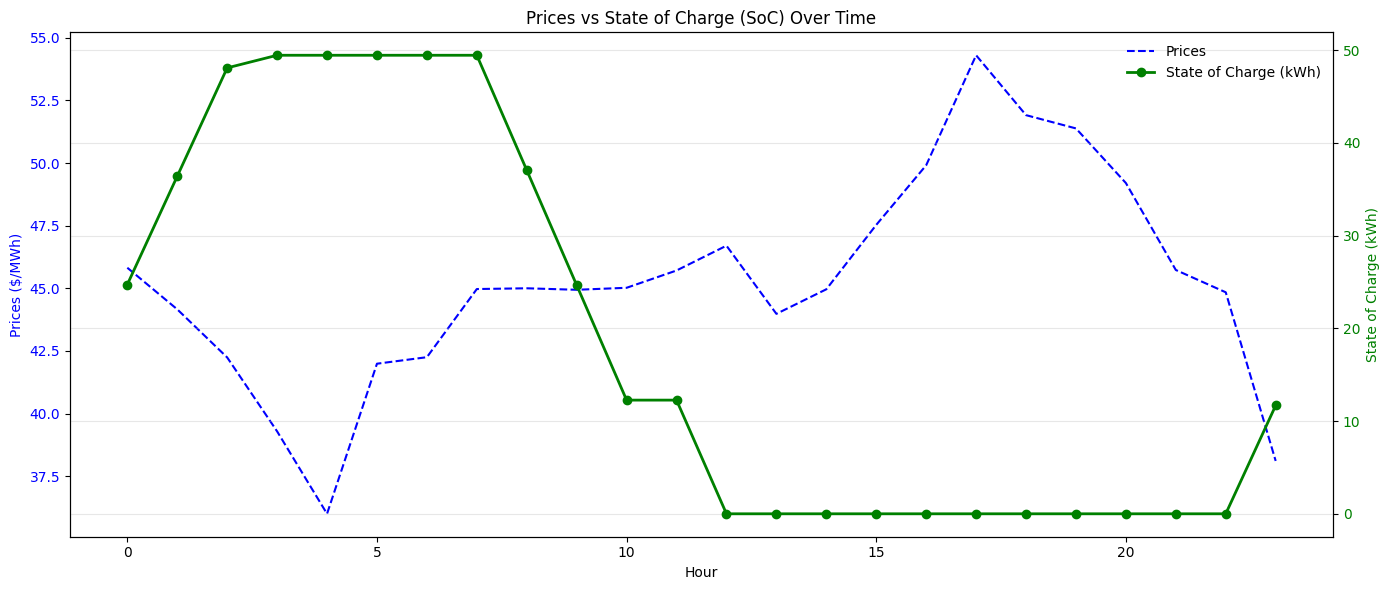

In [10]:
import numpy as np
import matplotlib.pyplot as plt

hours = np.arange(24)
fig, ax1 = plt.subplots(figsize=(14, 6))

# --- Primary axis (Prices) ---
ax1.plot(hours, day_info[0].prices_buy, '--b', label='Prices')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Prices ($/MWh)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# --- Secondary axis (State of Charge) ---
ax2 = ax1.twinx()
ax2.plot(hours, np.array(result_llm[0].soc[1:]) * battery.capacity_kwh,
         '-og', label='State of Charge (kWh)', linewidth=2, markersize=6)
ax2.set_ylabel('State of Charge (kWh)', color='g')
ax2.tick_params(axis='y', labelcolor='g')


# --- Legends ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best', frameon=False)

plt.title('Prices vs State of Charge (SoC) Over Time')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


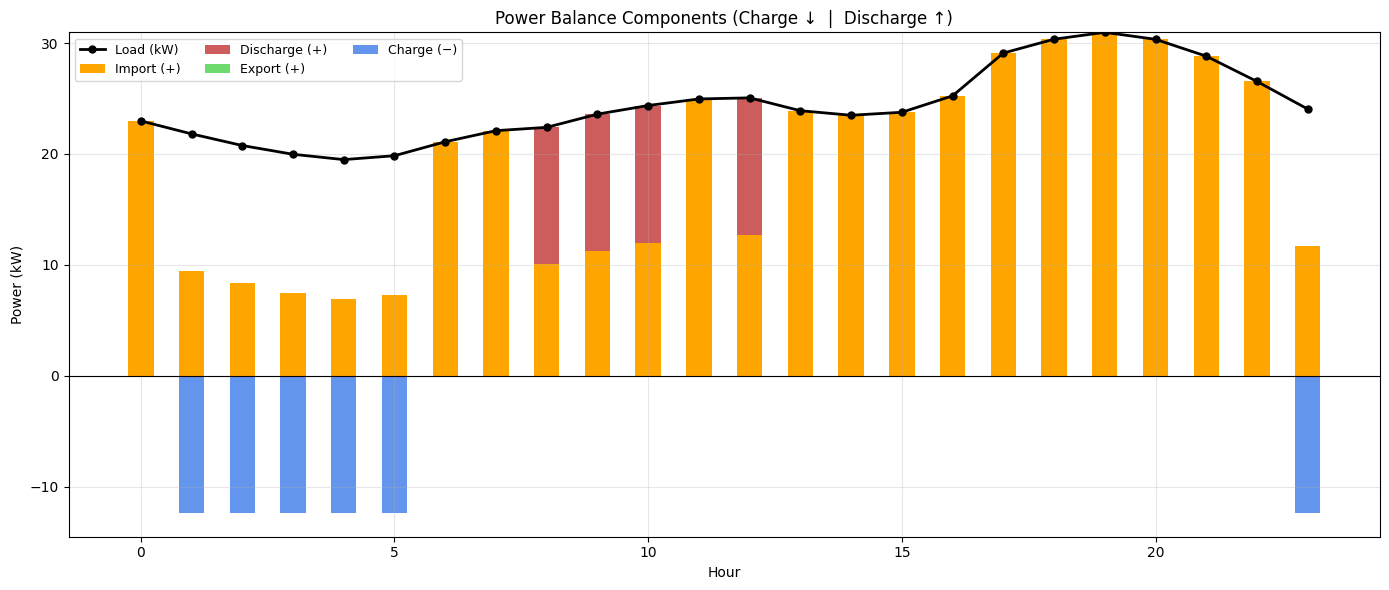

In [11]:
import numpy as np
import matplotlib.pyplot as plt

hours = np.arange(24)

# Data arrays
load = np.array(day_info[0].demand_kw)
charge = np.array(result_llm[0].charge_kw)
discharge = np.array(result_llm[0].discharge_kw)
import_kw = np.array(result_llm[0].import_kw)
export_kw = np.array(result_llm[0].export_kw) if getattr(day_info[0], "allow_export", False) else np.zeros_like(load)

# Flip battery convention for visualization
charge_vis = -charge       # show charge below 0
discharge_vis = discharge  # show discharge above 0

# ---------------------- PLOT ----------------------
fig, ax = plt.subplots(figsize=(14, 6))

# --- positive side stacking (Import + Discharge + Export) ---
# import is base layer
ax.bar(hours, import_kw, width=0.5, color='orange', label='Import (+)')
# discharge stacked on top of import
ax.bar(hours, discharge_vis, width=0.5, bottom=import_kw, color='indianred', label='Discharge (+)')
# export stacked on top (for clear separation)
ax.bar(hours, export_kw, width=0.5, bottom=import_kw + discharge_vis, color='limegreen', alpha=0.7, label='Export (+)')

# --- negative side stacking (Charge only) ---
ax.bar(hours, charge_vis, width=0.5, color='cornflowerblue', label='Charge (−)')

# --- Load as line ---
ax.plot(hours, load, '-ok', linewidth=2, markersize=5, label='Load (kW)')

# Formatting
ax.axhline(0, color='black', linewidth=0.8)
ax.set_ylabel("Power (kW)")
ax.set_xlabel("Hour")
ax.set_title("Power Balance Components (Charge ↓  |  Discharge ↑)")
ax.legend(ncol=3, loc='upper left', fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [12]:
total_objective_value = 0
for day_result in result_llm:
    total_objective_value += day_result.objective_cost
print(f"Total Objective Value over all days: ${total_objective_value:.2f} for {len(result_llm)} days")

Total Objective Value over all days: $984.74 for 1 days


In [17]:
result_llm[0].soc

[0.5,
 0.5,
 0.7362257279529826,
 0.9724514559059652,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.749373372768942,
 0.498646745537884,
 0.24792011830682603,
 0.24792011830682603,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.23622572795298247]

In [19]:
from typing import Sequence, Optional
def cost_from_soc(
    soc: Sequence[float],
    prices_buy: Sequence[float],
    demand_kw: Sequence[float],
    *,
    battery: BatteryParams,
    prices_sell: Optional[Sequence[float]] = None,
    allow_export: bool = False,
    dt_hours: float = 1.0,
):
    soc = np.asarray(soc, dtype=float)
    assert len(soc) >= 2, "SOC must include at least t=0 and t=1"
    T = len(soc) - 1

    prices_buy  = np.asarray(prices_buy, dtype=float)
    demand_kw   = np.asarray(demand_kw, dtype=float)
    assert len(prices_buy) == T and len(demand_kw) == T

    if prices_sell is None:
        prices_sell = prices_buy
    prices_sell = np.asarray(prices_sell, dtype=float)
    assert len(prices_sell) == T

    # Per-step energy change in kWh
    dE = (soc[1:] - soc[:-1]) * battery.capacity_kwh

    # Recover charge/discharge kW from SOC deltas and efficiencies
    charge_kw    = np.maximum(dE, 0.0) / (battery.eta_c * dt_hours)
    discharge_kw = np.maximum(-dE, 0.0) * (battery.eta_d / dt_hours)

    # Enforce hardware limits
    charge_kw    = np.minimum(charge_kw,    battery.cmax_kw)
    discharge_kw = np.minimum(discharge_kw, battery.dmax_kw)

    # Grid net load
    net = demand_kw + charge_kw - discharge_kw
    imp = np.maximum(net, 0.0)
    exp = np.maximum(-net, 0.0) if allow_export else np.zeros_like(net)

    # Cost (buy imports, optionally credit exports)
    cost = float(np.sum(prices_buy * imp * dt_hours) - np.sum(prices_sell * exp * dt_hours))

    out = {
        "charge_kw": charge_kw,
        "discharge_kw": discharge_kw,
        "import_kw": imp,
        "export_kw": exp,
        "net_kw": net,
        "objective_cost": cost,
    }
    return out

out = cost_from_soc(
    soc = result_llm[0].soc,
    prices_buy=day_info[0].prices_buy,
    demand_kw=day_info[0].demand_kw,
    battery=battery,
    prices_sell=day_info[0].prices_sell,
    allow_export=True,
    dt_hours=1
)
out["objective_cost"]

26188.63428773135

# Checking LLM Connection

In [13]:
# Reload environment variables and test with GPT-3.5-turbo
import os
from dotenv import load_dotenv
load_dotenv()  # Reload environment variables from .env file

# Test the LLM connection
from agentics.core.llm_connections import get_llm_provider
try:
    llm = get_llm_provider("gemini")
    response = llm.call("Hello! Can you briefly introduce yourself?")
    print("✅ LLM Connection Successful!")
    print(f"Response: {response}")
except Exception as e:
    print(f"❌ LLM Connection Failed: {e}")
    print("\nTroubleshooting options:")
    print("1. Check if your OpenAI API key is valid")
    print("2. Ensure you have sufficient OpenAI credits")
    print("3. Try using gpt-3.5-turbo instead of gpt-4")
    print("4. Consider using Gemini as an alternative")

2025-10-16 20:23:54.088 | DEBUG    | agentics.core.llm_connections:get_llm_provider:42 - Using specified LLM provider: gemini


Output()

✅ LLM Connection Successful!

Response: Hello! I am a large language model, trained by Google. I am designed to be informative and comprehensive.
I am trained on a massive amount of text data, and I can communicate and generate human-like text in response to a 
wide range of prompts and questions. For example, I can provide summaries of factual topics, create stories, and 
translate languages.